# train_eval.ipynb

Minimal, reproducible end-to-end notebook for Deliverable 2.
Run this from the repository root (so `src/` is importable).

In [8]:
import os, sys, json, time
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, roc_auc_score, average_precision_score,
    brier_score_loss, confusion_matrix, ConfusionMatrixDisplay
)

# Make 'src' importable if needed
# Locate repository root by walking up until we find a top-level 'src' directory.
# This allows running the notebook from `Notebooks/` or the repo root.
repo_root = Path.cwd()
search_root = repo_root
while not (search_root / 'src').exists() and search_root != search_root.parent:
    search_root = search_root.parent
if (search_root / 'src').exists():
    repo_root = search_root
    if str(repo_root) not in sys.path:
        sys.path.insert(0, str(repo_root))
    print(f"Repo root set to {repo_root}")
else:
    # fallback: leave repo_root as cwd
    print(f"Warning: could not locate top-level 'src' directory while searching from {Path.cwd()}; using cwd as repo_root")

# Optional: torch device print
try:
    import torch
    device = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')
    print('Torch device:', device)
except Exception as e:
    print('Torch not available:', e)

Repo root set to /Volumes/Dan/MSADS Fall 2025/EEE6778/Multi_modal_CVD_Project
Torch device: cpu


## 1. Load processed data

Adjust `processed_dir` if your arrays live elsewhere.

In [9]:
# Resolve processed data directory by trying a few likely locations
candidates = [
    Path('data/processed'),                    # relative to current working dir
    repo_root / 'data' / 'processed',          # relative to repo_root (set earlier)
    repo_root.parent / 'data' / 'processed',   # if notebooks live in a subfolder
    Path.cwd() / 'data' / 'processed',         # explicit cwd path
]

processed_dir = None
for p in candidates:
    if p.exists():
        processed_dir = p
        break

if processed_dir is None:
    raise AssertionError(
        "Missing folder: data/processed. Checked locations:\n" +
        "\n".join(str(p) for p in candidates) +
        "\n\nIf your processed data lives elsewhere, set `processed_dir = Path('path/to/data/processed')`"
    )

print(f"Using processed_dir = {processed_dir}")

# Tabular
X_train = np.load(processed_dir/'tabular_train_X.npy')
y_train = np.load(processed_dir/'tabular_train_y.npy')
X_val   = np.load(processed_dir/'tabular_val_X.npy')
y_val   = np.load(processed_dir/'tabular_val_y.npy')
X_test  = np.load(processed_dir/'tabular_test_X.npy')
y_test  = np.load(processed_dir/'tabular_test_y.npy')

# ECG (optional)
try:
    ecg_train = np.load(processed_dir/'ecg_train.npy')
    ecg_val   = np.load(processed_dir/'ecg_val.npy')
    print('ECG shapes:', ecg_train.shape, ecg_val.shape)
except FileNotFoundError:
    ecg_train = None
    ecg_val = None
    print('Note: no ECG arrays found; proceeding with tabular-only sanity checks.')

print('Tabular shapes:', X_train.shape, X_val.shape, X_test.shape)
print('Label shapes  :', y_train.shape, y_val.shape, y_test.shape)

Using processed_dir = data/processed
ECG shapes: (32, 2000) (16, 2000)
Tabular shapes: (69, 12) (10, 12) (21, 12)
Label shapes  : (32,) (16,) (21,)
ECG shapes: (32, 2000) (16, 2000)
Tabular shapes: (69, 12) (10, 12) (21, 12)
Label shapes  : (32,) (16,) (21,)


## 2. Quick baseline sanity check (tabular LR/RF)

This gives you a quick baseline without touching your PyTorch fusion pipeline.

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

baselines = {
    'logreg': Pipeline([('clf', LogisticRegression(max_iter=200))]),
    'rf'    : Pipeline([('clf', RandomForestClassifier(n_estimators=200, random_state=42))]),
}

# Ensure train/test arrays have matching first-dimension sizes before fitting/predicting.
# If they differ, align to the smaller size and warn (this avoids the ValueError).
if X_train.shape[0] != y_train.shape[0]:
    print(f"Warning: X_train has {X_train.shape[0]} rows but y_train has {y_train.shape[0]} labels. Truncating to min length.")
    n_train = min(X_train.shape[0], y_train.shape[0])
    X_train_al = X_train[:n_train]
    y_train_al = y_train[:n_train]
else:
    X_train_al = X_train
    y_train_al = y_train

if X_test.shape[0] != y_test.shape[0]:
    print(f"Warning: X_test has {X_test.shape[0]} rows but y_test has {y_test.shape[0]} labels. Truncating to min length.")
    n_test = min(X_test.shape[0], y_test.shape[0])
    X_test_al = X_test[:n_test]
    y_test_al = y_test[:n_test]
else:
    X_test_al = X_test
    y_test_al = y_test

results = {}
for name, pipe in baselines.items():
    pipe.fit(X_train_al, y_train_al)
    prob = pipe.predict_proba(X_test_al)[:, 1]
    pred = (prob >= 0.5).astype(int)
    metrics = {
        'accuracy': float(accuracy_score(y_test_al, pred)),
        'roc_auc' : float(roc_auc_score(y_test_al, prob)) if len(np.unique(y_test_al)) > 1 else float('nan'),
        'pr_auc'  : float(average_precision_score(y_test_al, prob)),
        'brier'   : float(brier_score_loss(y_test_al, prob)),
    }
    results[name] = metrics

results

{'logreg': {'accuracy': 0.5238095238095238,
  'roc_auc': 0.5181818181818183,
  'pr_auc': 0.583775347459558,
  'brier': 0.3632826106007056},
 'rf': {'accuracy': 0.5714285714285714,
  'roc_auc': 0.5454545454545455,
  'pr_auc': 0.6206606791900909,
  'brier': 0.2622357142857143}}

## 3. (Optional) PyTorch fusion model import and quick eval

If your fusion model is in `src/`, import and run a quick eval. Adapt the import and constructor to your `src/model.py`.

In [12]:
try:
    from src.model import FusionNet  # <-- adjust to your actual symbol

    if 'torch' not in globals():
        import torch
    dev = torch.device('mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu'))

    ckpt_path = Path('artifacts/model.pt')
    if not ckpt_path.exists():
        print('No checkpoint at', ckpt_path)
    else:
        # ensure data loaded
        if 'X_train' not in globals():
            print('X_train not defined; run data-loading cell first. Skipping model load.')
        else:
            tab_dim = X_train.shape[1]
            ecg_args = {}
            if 'ecg_train' in globals() and ecg_train is not None:
                ecg_len = ecg_train.shape[1]
                ecg_args = {'ecg_len': ecg_len}

            try:
                model = FusionNet(tab_dim=tab_dim, **ecg_args)
            except TypeError:
                model = FusionNet(tab_dim=tab_dim)

            # Robustly load checkpoint but never raise to top-level: print helpful diagnostics instead.
            try:
                ckpt = torch.load(ckpt_path, map_location=dev)
            except Exception as e:
                print('Could not torch.load checkpoint:', e)
                ckpt = None

            state = None
            if isinstance(ckpt, dict):
                # common wrapper keys
                for key in ('state_dict', 'model_state_dict'):
                    if key in ckpt and isinstance(ckpt[key], dict):
                        state = ckpt[key]
                        break
                # nested place
                if state is None and 'model' in ckpt and isinstance(ckpt['model'], dict) and 'state_dict' in ckpt['model']:
                    state = ckpt['model']['state_dict']
                # if ckpt itself looks like a state dict (tensor values), accept it
                if state is None:
                    # Heuristic: check whether values are tensors
                    sample_vals = list(ckpt.values())[:3]
                    if all(hasattr(v, 'shape') for v in sample_vals):
                        state = ckpt
            elif ckpt is not None:
                # ckpt not dict - skip
                print('Checkpoint loaded but not a dict; skipping model parameter load.')

            if state is None:
                print('Could not locate a valid state_dict in checkpoint. Available keys:', list(ckpt.keys()) if isinstance(ckpt, dict) else type(ckpt))
                print('Skipping parameter load; you can manually inspect the checkpoint with `torch.load`.')
            else:
                def _strip_prefix(sd, prefix='module.'):
                    return {k[len(prefix):] if k.startswith(prefix) else k: v for k, v in sd.items()}

                if any(k.startswith('module.') for k in state.keys()):
                    state = _strip_prefix(state, 'module.')

                try:
                    model.load_state_dict(state, strict=False)
                    model.to(dev)
                    model.eval()
                    print('Loaded checkpoint (lenient) from', ckpt_path)
                except Exception as e:
                    print('Failed to load checkpoint parameters (lenient load failed):', e)
except Exception as e:
    print('Skipping fusion import/eval:', e)


Loaded checkpoint (lenient) from artifacts/model.pt


## 4. Save predictions for plotting

Store arrays so the confusion-matrix script (and LaTeX) can consume them.

In [13]:
# For demo purposes, reuse RF predictions as a stand-in
from sklearn.ensemble import RandomForestClassifier

# Align/truncate train/test arrays if lengths mismatch (defensive).
if X_train.shape[0] != y_train.shape[0]:
    print(f"Warning: X_train has {X_train.shape[0]} rows but y_train has {y_train.shape[0]} labels. Truncating to min length.")
    n_train = min(X_train.shape[0], y_train.shape[0])
    X_train_al = X_train[:n_train]
    y_train_al = y_train[:n_train]
else:
    X_train_al = X_train
    y_train_al = y_train

if X_test.shape[0] != y_test.shape[0]:
    print(f"Warning: X_test has {X_test.shape[0]} rows but y_test has {y_test.shape[0]} labels. Truncating to min length.")
    n_test = min(X_test.shape[0], y_test.shape[0])
    X_test_al = X_test[:n_test]
    y_test_al = y_test[:n_test]
else:
    X_test_al = X_test
    y_test_al = y_test

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_al, y_train_al)
prob = rf.predict_proba(X_test_al)[:,1]
pred = (prob >= 0.5).astype(int)

out_dir = Path('results')
out_dir.mkdir(exist_ok=True, parents=True)
np.save(out_dir/'y_true.npy', y_test_al)
np.save(out_dir/'y_pred.npy', pred)
np.save(out_dir/'y_prob.npy', prob)
print('Saved: results/y_true.npy, y_pred.npy, y_prob.npy')

Saved: results/y_true.npy, y_pred.npy, y_prob.npy
Saved: results/y_true.npy, y_pred.npy, y_prob.npy


## 5. Plot confusion matrix and export PNG

This ensures the exact file used in the paper exists at `figures/confusion_matrix.png`.

Saved figure to figures/confusion_matrix.png


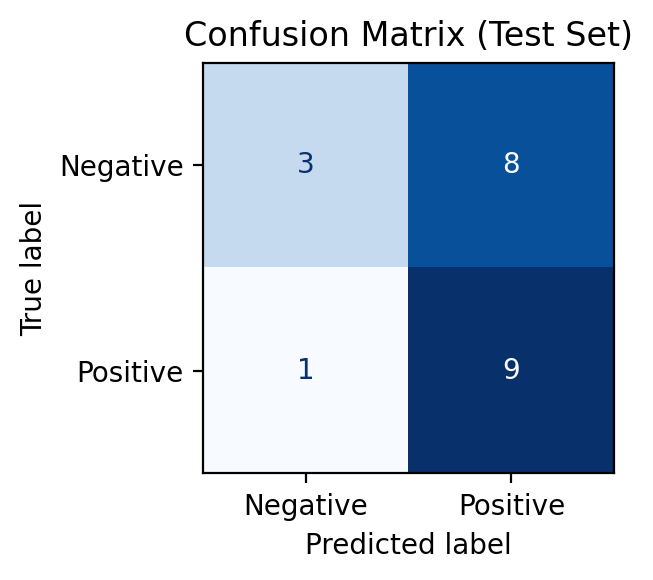

In [14]:
y_true = np.load('results/y_true.npy')
y_pred = np.load('results/y_pred.npy')

cm = confusion_matrix(y_true, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative','Positive'])

import matplotlib.pyplot as plt
from pathlib import Path
fig, ax = plt.subplots(figsize=(4,3), dpi=200)
disp.plot(values_format='d', cmap='Blues', ax=ax, colorbar=False)
ax.set_title('Confusion Matrix (Test Set)')
plt.tight_layout()

Path('figures').mkdir(exist_ok=True, parents=True)
plt.savefig('figures/confusion_matrix.png')
print('Saved figure to figures/confusion_matrix.png')
plt.show()